# Preprocess 10x and Hyrop v2 bigwigs to anndata format

In [4]:
import os
import anndata
import crested

In [2]:
bigwigs_folder = "../../../../../../../data/hydrop/fly_embryo/paper_zips/10x_hydropv2_comparisons_data/bigwigs" # change to the folder in your ZIP
regions_file = "../../../../../../../data/hydrop/fly_embryo/paper_zips/10x_hydropv2_comparisons_data/consensus_regions_LCB_dechor_embryo_atlas_v1_082024.bed"
chromsizes_file = "../../../../../../../../eceksi/resources/dmel/no_chr/dm6_chrombpnet_filtered_nochr.chrom.sizes"
genome_file = "../../../../../../../../eceksi/resources/dmel/no_chr/dm6_nochr_filtered.fa"

## Hydrop

In [5]:
adata = crested.import_bigwigs(
    bigwigs_folder=os.path.join(bigwigs_folder, "hydrop"),
    regions_file=regions_file,
    target_region_width=500,
    target="mean",
    chromsizes_file=chromsizes_file
)
adata

2025-07-29T14:32:10.651299+0200 INFO Extracting values from 20 bigWig files...


AnnData object with n_obs × n_vars = 20 × 95819
    obs: 'file_path'
    var: 'chr', 'start', 'end'

In [6]:
crested.pp.train_val_test_split(
    adata, strategy="chr", val_chroms=["2R"], test_chroms=["2R"]
)
print(adata.var["split"].value_counts())

split
train    77751
val       9034
test      9034
Name: count, dtype: int64


In [7]:
from utils import normalize_accessibility_per_chromosome
adata = normalize_accessibility_per_chromosome(adata, target_mean=0.5)

/lustre1/project/stg_00002/lcb/lmahieu/projects/HyDrop/HyDrop_v2_paper/fly_embryo/CREsted/10x_hydrop_comparisons/preprocess/utils.py:143: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df.groupby(chromosomes, axis=1).mean().mean(axis=0)


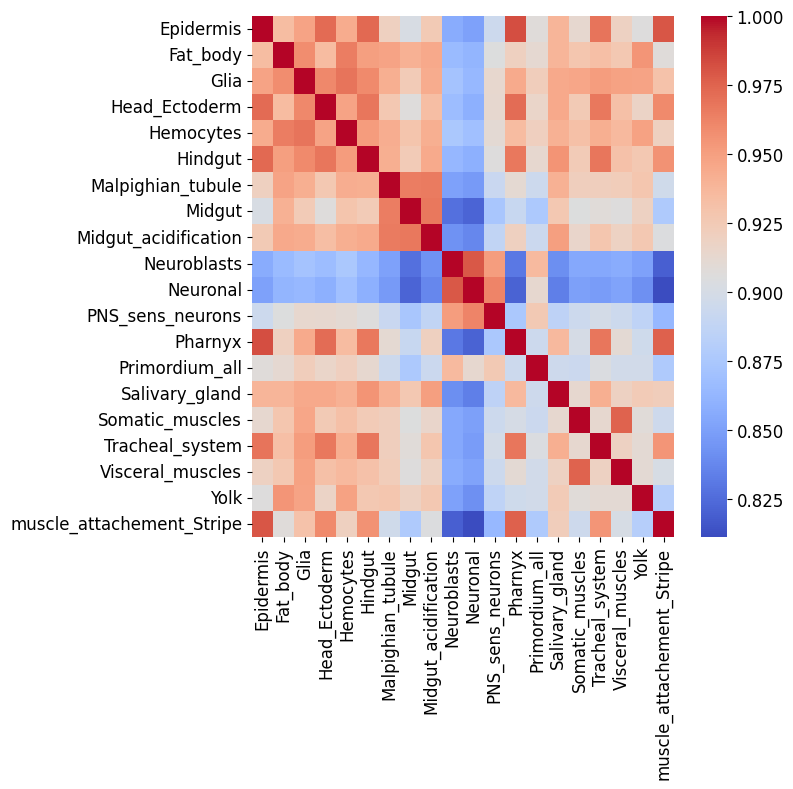

In [9]:
%matplotlib inline
crested.pl.heatmap.correlations_self(adata, x_label_rotation=90)

In [10]:
print(adata.var["split"].value_counts())

split
train    77751
val       9034
test      9034
Name: count, dtype: int64


In [11]:
# correct region filtering
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
zscores = zscore(adata.X, axis=0)
zscores_df = pd.DataFrame(zscores.T)
data_df = pd.DataFrame(adata.X).T
first_n = 3000
regions_np = np.zeros(adata.X.shape)
for i in range(adata.X.shape[0]):
    for region in zscores_df.sort_values(i, ascending=False).index[:first_n]:
        regions_np[i, region] = 1
no_filter = []
for region in range(adata.X.shape[1]):
    if any(regions_np[:, region] != 0):
        no_filter.append(adata.var_names[region])
adata.X = adata.X*regions_np
adata._inplace_subset_var(no_filter)

In [12]:
adata

AnnData object with n_obs × n_vars = 20 × 55625
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'split'

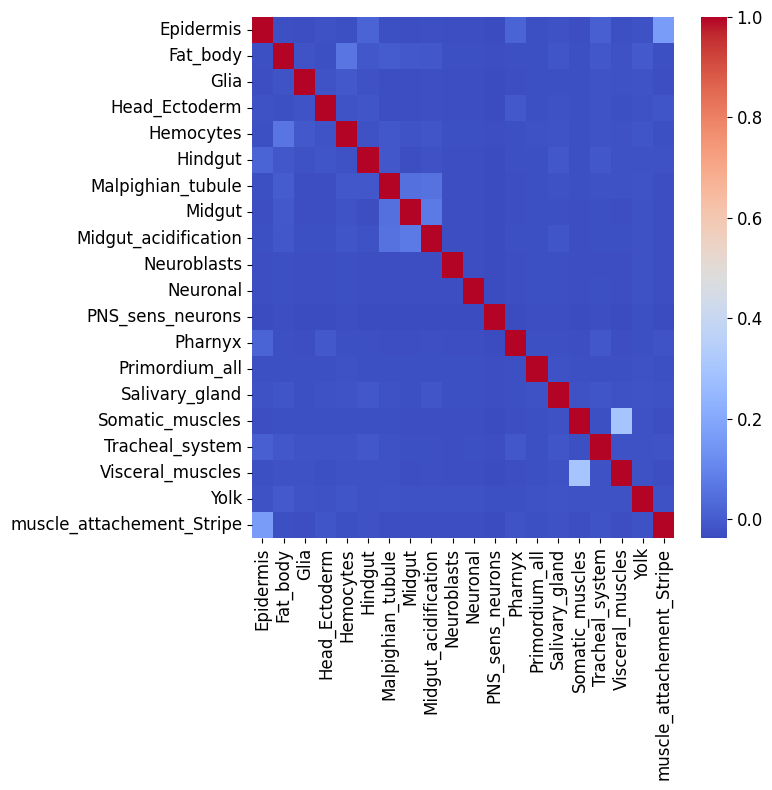

In [13]:
%matplotlib inline
crested.pl.heatmap.correlations_self(adata, x_label_rotation=90)

In [25]:
# save
adata.write_h5ad("../data/hydrop_fly.h5ad")

## 10x

In [14]:
adata = crested.import_bigwigs(
    bigwigs_folder=os.path.join(bigwigs_folder, "10x"),
    regions_file=regions_file,
    target_region_width=500,
    target="mean",
    chromsizes_file=chromsizes_file
)
adata

2025-07-29T14:36:24.771336+0200 INFO Extracting values from 20 bigWig files...


AnnData object with n_obs × n_vars = 20 × 95819
    obs: 'file_path'
    var: 'chr', 'start', 'end'

In [15]:
from utils import normalize_accessibility_per_chromosome
adata = normalize_accessibility_per_chromosome(adata, target_mean=0.5)

/lustre1/project/stg_00002/lcb/lmahieu/projects/HyDrop/HyDrop_v2_paper/fly_embryo/CREsted/10x_hydrop_comparisons/preprocess/utils.py:143: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df.groupby(chromosomes, axis=1).mean().mean(axis=0)


In [16]:
# correct region filtering
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
zscores = zscore(adata.X, axis=0)
zscores_df = pd.DataFrame(zscores.T)
data_df = pd.DataFrame(adata.X).T
first_n = 3000
regions_np = np.zeros(adata.X.shape)
for i in range(adata.X.shape[0]):
    for region in zscores_df.sort_values(i, ascending=False).index[:first_n]:
        regions_np[i, region] = 1
no_filter = []
for region in range(adata.X.shape[1]):
    if any(regions_np[:, region] != 0):
        no_filter.append(adata.var_names[region])
adata.X = adata.X*regions_np
adata._inplace_subset_var(no_filter)

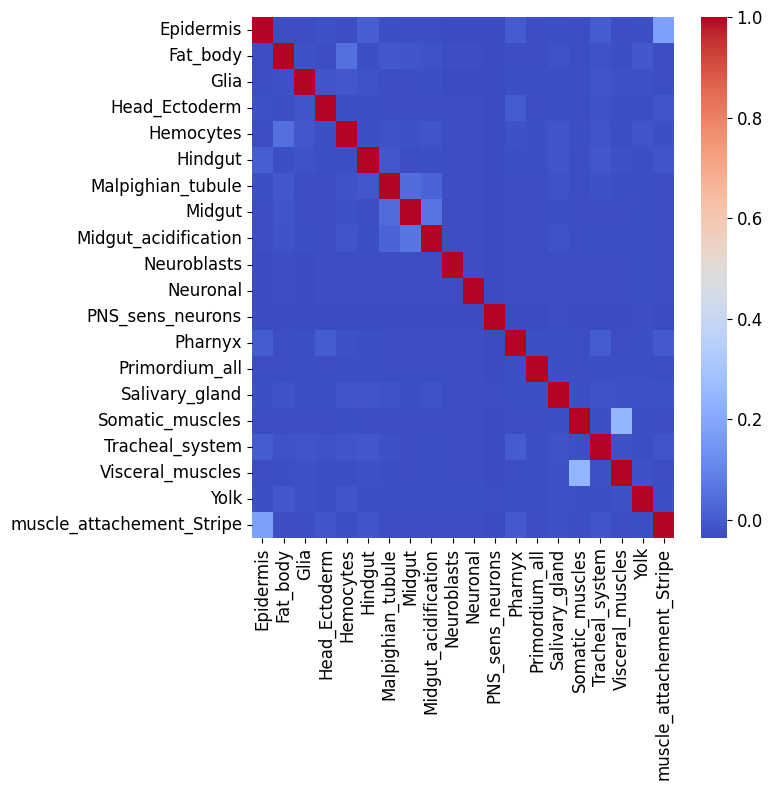

In [17]:
crested.pl.heatmap.correlations_self(adata, x_label_rotation=90)

In [18]:
adata.write_h5ad("../data/10x_fly.h5ad")